<a href="https://colab.research.google.com/github/SamiraHabib/System_Recomendation_AV2-IA-/blob/main/IA_AV2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**SISTEMA DE RECOMENDAÇÃO** - 
    
    RECOMENDAÇÃO DE FILMES


```
https://www.kaggle.com/code/kanncaa1/recommendation-systems-tutorial/data
```



####Imports

In [79]:
!pip install -q scikit-surprise
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

####Dataset

##### - Books

In [81]:
movies = pd.read_csv("https://raw.githubusercontent.com/SamiraHabib/System_Recomendation_AV2-IA-/main/movie.csv", encoding='latin-1')
print('Rows:', movies.shape[0], '/ Columns:', movies.shape[1], '\n')
movies.head()

Rows: 27278 / Columns: 3 



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


##### - Ratings

In [82]:
ratings = pd.read_csv("/content/sample_data/rating.csv", encoding='latin-1', nrows=70000)
print('Rows:', ratings.shape[0], '/ Columns:', ratings.shape[1], '\n')
ratings

Rows: 70000 / Columns: 4 



,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
69995,489,208,4.0,2002-07-08 16:21:07
69996,489,231,5.0,2002-07-08 16:19:11
69997,489,232,4.0,1999-03-07 14:17:01
69998,489,241,2.0,2002-07-08 16:20:05


In [83]:
ratings['rating'].unique()

array([3.5, 4. , 3. , 4.5, 5. , 2. , 1. , 2.5, 0.5, 1.5])

####Conhecendo os dataframes

In [84]:
print("Book Shape: " ,movies.shape )
print("Rating Shape: " ,ratings.shape )

Book Shape:  (27278, 3)
Rating Shape:  (70000, 4)


In [85]:
print( "Books: \n\n\n", movies.describe(), "\n\n\nRatings: \n\n\n",  ratings.describe())

Books: 


              movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000 


Ratings: 


              userId        movieId        rating
count  70000.000000   70000.000000  70000.000000
mean     261.275729    8367.081629      3.493971
std      139.893485   18822.135879      1.077329
min        1.000000       1.000000      0.500000
25%      135.000000     832.000000      3.000000
50%      271.000000    2107.000000      3.500000
75%      387.000000    4344.000000      4.000000
max      489.000000  128488.000000      5.000000


In [86]:
print("Quantidade de nulos em Books:\n" ,movies.isnull().sum())
print("\n\nQuantidade de nulos em Ratings:\n",ratings.isnull().sum())

Quantidade de nulos em Books:
 movieId    0
title      0
genres     0
dtype: int64


Quantidade de nulos em Ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


##Preprocessamento

#### Juntando os dataframes

In [87]:
df_movie = ratings.merge(movies,on="movieId")
df_movie.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


In [88]:
df_movie.nunique()

userId         489
movieId       7394
rating          10
timestamp    53432
title         7392
genres         807
dtype: int64

In [89]:
df_movie.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [90]:
df=df_movie.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["timestamp"],axis=1,inplace=True)
#df.drop(index=df[df["rating"]==0].index,inplace=True)
df["title"]=df["title"].apply(lambda x: re.sub("(?: \(\d{4}\))$","",x).strip())
df.rename(columns = {'movieId': 'MovieID','title':'Movie_Title', 'userId': 'UserID', 'rating': 'Movie_Rating', 'genres': 'Genres'}, inplace = True)
df.head()

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
0,1,2,3.5,Jumanji,Adventure|Children|Fantasy
1,5,2,3.0,Jumanji,Adventure|Children|Fantasy
2,13,2,3.0,Jumanji,Adventure|Children|Fantasy
3,29,2,3.0,Jumanji,Adventure|Children|Fantasy
4,34,2,3.0,Jumanji,Adventure|Children|Fantasy


In [91]:
df= df.dropna()

In [92]:
df[df["Movie_Rating"] == 0.5]

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
58,427,2,0.5,Jumanji,Adventure|Children|Fantasy
631,88,151,0.5,Rob Roy,Action|Drama|Romance|War
1006,427,260,0.5,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
1018,469,260,0.5,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
1163,110,296,0.5,Pulp Fiction,Comedy|Crime|Drama|Thriller
...,...,...,...,...,...
69721,440,5691,0.5,Jason Goes to Hell: The Final Friday,Action|Horror
69726,440,54274,0.5,I Know Who Killed Me,Crime|Drama|Thriller
69730,440,65155,0.5,"Surfer, Dude",Comedy
69731,440,66783,0.5,Friday the 13th,Horror


In [93]:
df.tail()

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
69995,486,54198,3.0,Boris and Natasha,Action|Comedy
69996,486,56176,4.0,Alvin and the Chipmunks,Children|Comedy
69997,486,57370,4.0,Mad Money,Comedy|Crime|Thriller
69998,486,66304,2.5,Hotel for Dogs,Adventure|Children|Comedy
69999,487,7374,2.0,Home on the Range,Animation|Children|Comedy|Musical|Western


In [94]:
df.shape

(70000, 5)

##Agrupando dados

In [95]:
df_rating = df.groupby(by=['Movie_Rating']).agg({'UserID': 'count'}).reset_index()
df_rating.columns = ['Rating', 'Count']

#####Visualização dos dados

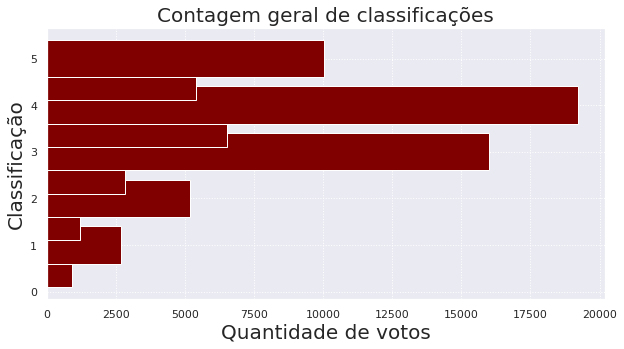

In [96]:
fig = plt.figure(figsize=(10, 5))
plt.barh(df_rating.Rating, df_rating.Count, color='maroon')
plt.title('Contagem geral de classificações', fontsize=20)
plt.xlabel('Quantidade de votos', fontsize=20)
plt.ylabel('Classificação', fontsize=20)
plt.grid(ls='dotted')
plt.show()

In [97]:
df_visualization = df.groupby('UserID').Movie_Rating.count().sort_values(ascending=False)

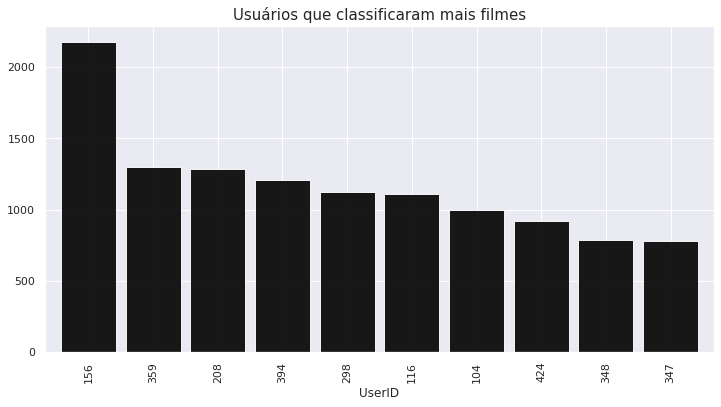

In [98]:
# Plotando o top 10 raters
plt.figure(figsize=(12,6))
df_visualization.head(10).plot(kind='bar', alpha=0.9, width=0.85, color='black')
plt.title("Usuários que classificaram mais filmes", size=15)
plt.show()

In [99]:
df_title = df.dropna()

In [100]:
df_title.head()

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
0,1,2,3.5,Jumanji,Adventure|Children|Fantasy
1,5,2,3.0,Jumanji,Adventure|Children|Fantasy
2,13,2,3.0,Jumanji,Adventure|Children|Fantasy
3,29,2,3.0,Jumanji,Adventure|Children|Fantasy
4,34,2,3.0,Jumanji,Adventure|Children|Fantasy


In [101]:
df_title=df.sort_values(by='Movie_Rating', ascending=False)

In [102]:
#Visualização de avialiação de usuários por título de filme
import plotly.express as px
top_rated=df_title[0:30]
fig =px.sunburst(
    top_rated,
    path=['UserID','Movie_Title'],
    values='Movie_Rating',
    color='Movie_Title')
fig.show()

In [103]:
# Quantidade de usuários que avalariaram mais de 50 filmes
print(f'Avaliaram 50 ou mais filmes: {sum(df_visualization>=50)}')
print(f'Avaliaram mais de 50 filmes: {sum(df_visualization>50)}')

Avaliaram 50 ou mais filmes: 319
Avaliaram mais de 50 filmes: 311


In [104]:
# Dataframe com filmes que tem mais de 100 avaliações de usuários
df_top=df.groupby("MovieID").filter(lambda x:x['Movie_Rating'].count() >=100)

In [105]:
df_top

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
111,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
112,3,32,4.0,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
113,4,32,1.0,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
114,11,32,5.0,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
115,12,32,3.0,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
...,...,...,...,...,...
34799,474,34,5.0,Babe,Children|Drama
34800,479,34,4.0,Babe,Children|Drama
34801,481,34,4.0,Babe,Children|Drama
34802,485,34,3.0,Babe,Children|Drama


In [106]:
df_top.Movie_Title.unique()

array(['Twelve Monkeys (a.k.a. 12 Monkeys)', 'Seven (a.k.a. Se7en)',
       'Usual Suspects, The',
       'Interview with the Vampire: The Vampire Chronicles',
       'Star Wars: Episode IV - A New Hope', 'Pulp Fiction',
       'Shawshank Redemption, The', 'Mask, The', 'Blade Runner',
       'Terminator 2: Judgment Day', 'Silence of the Lambs, The',
       'E.T. the Extra-Terrestrial', 'Monty Python and the Holy Grail',
       'Star Wars: Episode V - The Empire Strikes Back',
       'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)',
       'Alien', 'Terminator, The', 'Indiana Jones and the Last Crusade',
       'Star Wars: Episode I - The Phantom Menace', 'Sixth Sense, The',
       'Fight Club', 'Memento', 'Shrek',
       'Lord of the Rings: The Fellowship of the Ring, The',
       'Lord of the Rings: The Two Towers, The',
       'Lord of the Rings: The Return of the King, The', 'Braveheart',
       'Jurassic Park', 'Star Wars: Episode VI - Return of the Jedi',


In [107]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [108]:
df.head()

,UserID,MovieID,Movie_Rating,Movie_Title,Genres
0,1,2,3.5,Jumanji,Adventure|Children|Fantasy
1,5,2,3.0,Jumanji,Adventure|Children|Fantasy
2,13,2,3.0,Jumanji,Adventure|Children|Fantasy
3,29,2,3.0,Jumanji,Adventure|Children|Fantasy
4,34,2,3.0,Jumanji,Adventure|Children|Fantasy


##Criação de perfil de Usuário

In [109]:
all_genres = [s.split("|") for s in df[df.Genres.notnull()].Genres]
unique_genres = sorted(set([item for l in all_genres for item in l ]))

movie_genres = df.copy(deep=True)
movie_genres['Genres'] = movie_genres.Genres.str.split('|')
for g in unique_genres:
    movie_genres[g] = np.zeros(len(movie_genres))

for index, row in movie_genres.iterrows():
    for genre in row['Genres']:
        movie_genres.at[index, genre] = 1

movie_genres.drop(['Movie_Title','Genres','UserID', 'Movie_Rating'], axis=1, inplace=True)

In [110]:
movie_genres

,MovieID,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,54198,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,56176,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,57370,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69998,66304,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


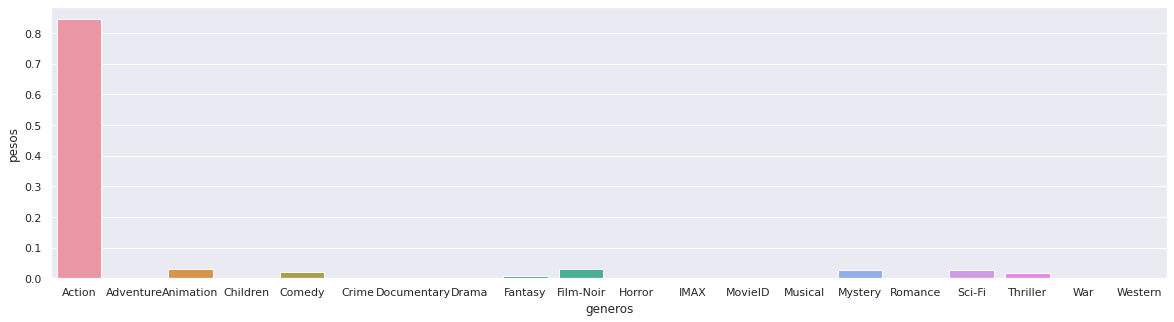

In [111]:
def create_user_profile(user=None, user_ratings=None):
    if ((user is None) & (user_ratings is None)) | ((user is not None) & (user_ratings is not None)):
        raise Exception('Necessário informar um usuário ou classificações')
    user_ratings = ratings[ ratings['userId'] == user ][['movieId', 'rating']]
    # Valida se todas as classificações são de filmes válidos
    user_ratings = user_ratings[ user_ratings.index.isin(movie_genres.index) ]
    # Calcular o peso de cada gênero para o usuário ou user_ratings
    userdf = movie_genres[ movie_genres.index.isin(user_ratings.index) ].copy()
    up = userdf.T.dot(user_ratings.rating) /  sum(userdf.T.dot(user_ratings.rating))
    return up

import seaborn as sns

def plot_user_profile(user_profile):
    genres = pd.DataFrame(zip(list(user_profile), sorted(user_profile.keys())), columns=['pesos', 'generos'])
    sns.set(rc={'figure.figsize':(20,5)})
    ax = sns.barplot(x="generos", y="pesos", data=genres)

plot_user_profile(create_user_profile(user=1))

## Recomenadação User-User

In [112]:
#Lendo o dataset
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df[['UserID', 'MovieID','Movie_Rating']], reader)

In [113]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()

ausentes = trainset.build_anti_testset()

In [114]:
trainset.all_items()

range(0, 7394)

In [115]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=3, n_jobs=2, verbose=0)

In [116]:
modelo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})

# Analisa os dados dos usuários similares
modelo.fit(trainset)

# Realiza as predições
kMeans_test_predictions = modelo.test(testset)

# Exibe os resultados
df_final = pd.DataFrame(kMeans_test_predictions)
df_final

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,1,2,3.5,3.594630,"{'actual_k': 10, 'was_impossible': False}"
1,1,29,3.5,3.595962,"{'actual_k': 10, 'was_impossible': False}"
2,1,32,3.5,3.477257,"{'actual_k': 10, 'was_impossible': False}"
3,1,47,3.5,3.665261,"{'actual_k': 10, 'was_impossible': False}"
4,1,50,3.5,3.642994,"{'actual_k': 10, 'was_impossible': False}"
...,...,...,...,...,...
69995,464,1347,2.5,2.460775,"{'actual_k': 10, 'was_impossible': False}"
69996,464,2145,2.0,2.027698,"{'actual_k': 8, 'was_impossible': False}"
69997,464,994,2.0,1.998700,"{'actual_k': 7, 'was_impossible': False}"
69998,464,799,1.5,1.551674,"{'actual_k': 3, 'was_impossible': False}"


In [118]:
df_final = df_final.pivot_table(values='est', index='uid', columns='iid')
df_final.head()

iid,1,2,3,4,5,6,7,8,9,10,...,116799,116841,117176,117511,117590,118354,118696,119141,125916,128488
uid,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.594630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.053259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.173553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.309256,NaN,NaN,NaN,4.016438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.436576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
#RMSE
print(accuracy.rmse(kMeans_test_predictions, verbose=True))

RMSE: 0.2558
0.2557741590021059


####Recomendações

In [120]:
teste = []
for m in df.index:
    teste.append( (-1,m,0) )

predictions = modelo.test(teste)
pd.DataFrame(predictions, columns=['user', 'movie_id', 'rating', 'pred_rating', 'details']).drop(['details'], axis=1)

,user,movie_id,rating,pred_rating
0,-1,0,0,3.493971
1,-1,1,0,3.493971
2,-1,2,0,3.493971
3,-1,3,0,3.493971
4,-1,4,0,3.493971
...,...,...,...,...
69995,-1,69995,0,3.493971
69996,-1,69996,0,3.493971
69997,-1,69997,0,3.493971
69998,-1,69998,0,3.493971


In [121]:
def get_recommendations(best, ausentes, user, topN=10):
    teste = list(filter(lambda x: x[0]==user, ausentes))
    predictions = best.test(teste)
    df_preds = pd.DataFrame(predictions, columns=['user', 'movie_id', 'rating', 'pred_rating', 'details']).drop(['details'], axis=1)
    colunas = ['movie_id', 'Movie_Title', 'Genres', 'pred_rating', 'Movie_Rating']
    return df_preds.join(df, on='movie_id')[colunas].sort_values(by=['pred_rating','Movie_Rating'], ascending=False).head(topN)

In [123]:
get_recommendations(modelo, ausentes, user=1)

,movie_id,Movie_Title,Genres,pred_rating,Movie_Rating
5448,1306,Pulp Fiction,Comedy|Crime|Drama|Thriller,6.409524,4.0
6519,7649,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,6.166528,4.0
6811,7811,Dragonslayer,Action|Adventure|Fantasy,6.166528,4.0
6812,7812,Dragonslayer,Action|Adventure|Fantasy,6.166528,4.0
6810,7810,"Brotherhood of the Wolf (Pacte des loups, Le)",Action|Mystery|Thriller,6.166528,1.0
4514,5235,Poltergeist,Horror|Thriller,6.158035,3.5
3675,6329,"Christmas Story, A",Children|Comedy,6.105226,2.0
4666,219,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller,5.903571,4.0
3157,2131,"Silence of the Lambs, The",Crime|Horror|Thriller,5.892156,4.0
3139,1934,Terminator 2: Judgment Day,Action|Sci-Fi,5.841281,3.5


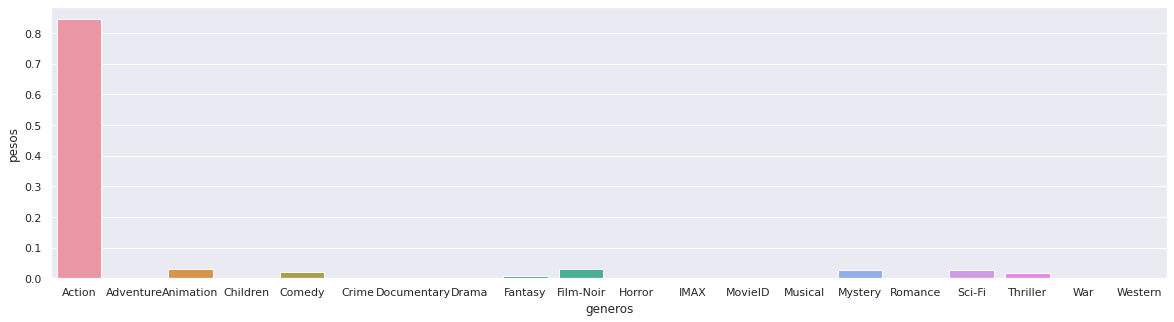

In [122]:
plot_user_profile(create_user_profile(user=1))